In [1]:
import jax
#jax.config.update('jax_platform_name', 'cpu')
from jax import jit
from emlp_jax.equivariant_subspaces import tensor_drho, tensor_drho_lazy, T, tensor_rho,tensor_rho_lazy,tensor_constraints_lazy
from emlp_jax.groups import *
import numpy as np
import jax.numpy as jnp
from oil.utils.mytqdm import tqdm
import optax

In [2]:
# drl = tensor_drho_lazy(M,rank)
# dr = tensor_drho(M,rank)
# U,S,VT = np.linalg.svd(dr,full_matrices=True)
# rank = (S<1e-6).sum()
#c = drl.shape[0]

In [3]:
#C = tensor_constraints_lazy(SO13p(),(6,0))
#C = tensor_constraints_lazy(RubiksCube(),(3,0))
C = tensor_constraints_lazy(S(50),(2,0))
c = C.shape[-1]

RuntimeError: Internal: Unable to launch cuBLAS gemm on stream 0x55b3b68d6200

In [4]:
r=20

  0%|          | 0/60000 [00:00<?, ?it/s]

4


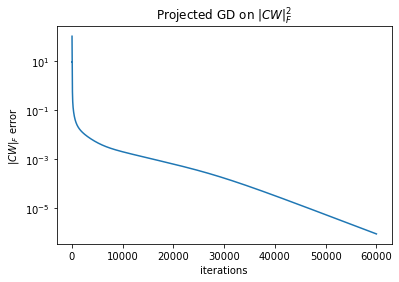

In [7]:
r=20
# Projected Gradient descent on \|CW\|^2 with Nesterov Momentum
W = np.random.randn(c,r)
W /= np.sqrt((W**2).sum(0,keepdims=True))
#lr = 3e-2
m= .9
tol=1e-4

lr=1e-2
opt_init,opt_update = optax.sgd(lr,m)#optax.adam(lr)#optax.sgd(3e-3,.9)#optax.adam(lr)
opt_state = opt_init(W)  # init stats

def loss(W):
    return ((C@W)**2).sum()/2

loss_and_grad = jit(jax.value_and_grad(loss))

lossvalues = []
for i in tqdm(range(60000)):
    lossval, grad = loss_and_grad(W)#jax.value_and_grad(loss)(W)
    #grads = jax.grad(loss)(W)
    updates, opt_state = opt_update(grad, opt_state, W)
    W = optax.apply_updates(W, updates)
    W /= jnp.sqrt((W**2).sum(0,keepdims=True))
    lossvalues.append(lossval)
    if lossval <tol**2: break
    if lossval> 1e2 and i>100: break
if lossval>1e-2: # Failed to converge means subspace has dimension 0 
    W*=0
    
U,s,VT = np.linalg.svd(np.array(W),full_matrices=False) # Changed from full_matrices=True
rank = (s>tol).sum()
Q = VT[:rank].T
# Q,R = jnp.linalg.qr(W)
# rank = (jnp.abs(jnp.diag(R))>1e-2).sum()
# Q = Q[:,:rank]
print(rank)
import matplotlib.pyplot as plt
plt.plot(np.arange(len(lossvalues)),lossvalues)
plt.title(r'Projected GD on $\|CW\|_F^2$')
plt.yscale('log')
plt.ylabel(r'$\|CW\|_F$ error')
plt.xlabel('iterations')
plt.show()


In [8]:
s

array([3.2557774e+00, 3.0656548e+00, 3.9522458e-02, 1.0734554e-02,
       9.4506713e-06, 6.1890646e-06, 4.9463465e-06, 4.6126770e-06,
       3.6358733e-06, 2.7089375e-06, 2.5223849e-06, 1.2804844e-06,
       9.3230153e-07, 8.7054548e-07, 8.0516003e-07, 6.6611068e-07,
       5.0642603e-07, 4.9168227e-07, 1.8700931e-07, 7.7085453e-08],
      dtype=float32)

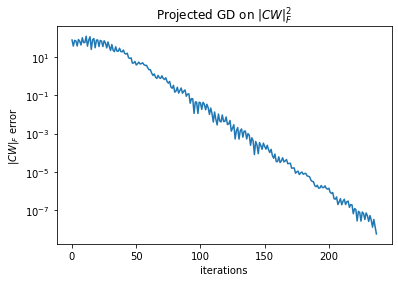

In [8]:
plt.plot(np.arange(len(lossvalues)),lossvalues)
plt.title(r'Projected GD on $\|CW\|_F^2$')
plt.yscale('log')
plt.ylabel(r'$\|CW\|_F$ error')
plt.xlabel('iterations')
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

10


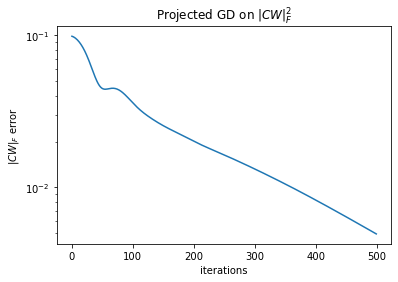

In [21]:
# Projected Gradient descent on \|CW\|^2 with Nesterov Momentum
W = np.random.randn(c,r)
lr = 1e-2
m= .96
v = np.zeros_like(W)
g = np.zeros_like(W)
gradnorms = []
for i in tqdm(range(500)):
    W /= np.sqrt((W**2).sum(0,keepdims=True))
    #W = np.linalg.qr(W)[0]
    g = AW = C.T@(C@(W-lr*m*v))
    #W -= lr*g
    v += (1-m)*(g-v)
    W -= lr*v
    gradnorms.append(np.sqrt((AW**2).mean()))
Q,R = np.linalg.qr(W)
rank = (np.abs(np.diag(R))>1e-2).sum()
Q = Q[:,:rank]
print(rank)
import matplotlib.pyplot as plt
plt.plot(np.arange(len(gradnorms)),gradnorms)
plt.title(r'Projected GD on $\|CW\|_F^2$')
plt.yscale('log')
plt.ylabel(r'$\|CW\|_F$ error')
plt.xlabel('iterations')
plt.show()

In [56]:
T(2)(RubiksCube()).equivariant_basis().shape[0]

6

In [50]:
Q[:,1]+Q[:,0]*(1-Q[0,1])/Q[0,0]

array([ 1.       , -0.3340019, -0.3340019, -0.3340019, -0.3340019,
       -0.3340019,  1.       , -0.3340019, -0.3340019, -0.3340019,
       -0.3340019, -0.3340019,  1.       , -0.3340019, -0.3340019,
       -0.3340019, -0.3340019, -0.3340019,  1.       , -0.3340019,
       -0.3340019, -0.3340019, -0.3340019, -0.3340019,  1.       ])

In [32]:
np.linalg.svd(W)[1]

array([1.95315231e+00, 1.47952160e+00, 1.40592227e+00, 9.96233101e-01,
       8.75958622e-01, 5.09714559e-01, 8.63838357e-04, 6.88866981e-04,
       5.10607074e-04, 3.57886520e-04])

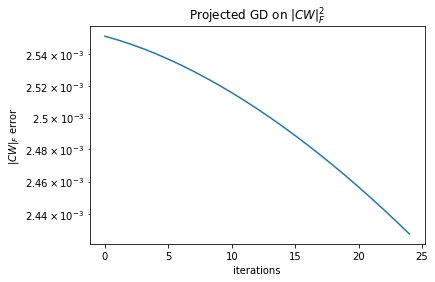

In [11]:
plt.plot(np.arange(len(gradnorms)),gradnorms)
plt.title(r'Projected GD on $\|CW\|_F^2$')
plt.yscale('log')
plt.ylabel(r'$\|CW\|_F$ error')
plt.xlabel('iterations')
plt.show()

In [21]:
violation = C.T@(C@Q)

In [23]:
np.mean(np.abs(violation))

0.07365409901470757